# Implementation of Logistic Regression in Python

### Dataset is downloaded from https://data.world/exercises/logistic-regression-exercise-1
Dataset for practicing classification -use NBA rookie stats to predict if player will last 5 years in league. 

Output feature in dataset:
y = 0 if career years played < 5
y = 1 if career years played >= 5

<img src="https://data.world/api/exercises/dataset/logistic-regression-exercise-1/file/raw/Screen%20Shot%202017-01-25%20at%2010.20.38%20AM.png" width="400" height="200"/>

## Import required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

## Read breast cancer dataset from sklearn datasets

In [2]:
df = pd.read_csv("nba_logreg.csv")
df

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,...,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0
1336,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0
1337,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,...,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0.0
1338,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0


In [3]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
X = df.drop('TARGET_5Yrs',axis=1)
# Encode labels in column 'species'.
X['Name']= label_encoder.fit_transform(X['Name'])
 
X['Name'].unique()
X
Y = df['TARGET_5Yrs']

## Check all logistic regression assumptions
### i. The dependent variable must be binary in a binary logistic equation.

In [4]:
df['TARGET_5Yrs'].unique()

array([0., 1.])

The response variable is binary.

### iii. Check multicolinearity

<AxesSubplot:>

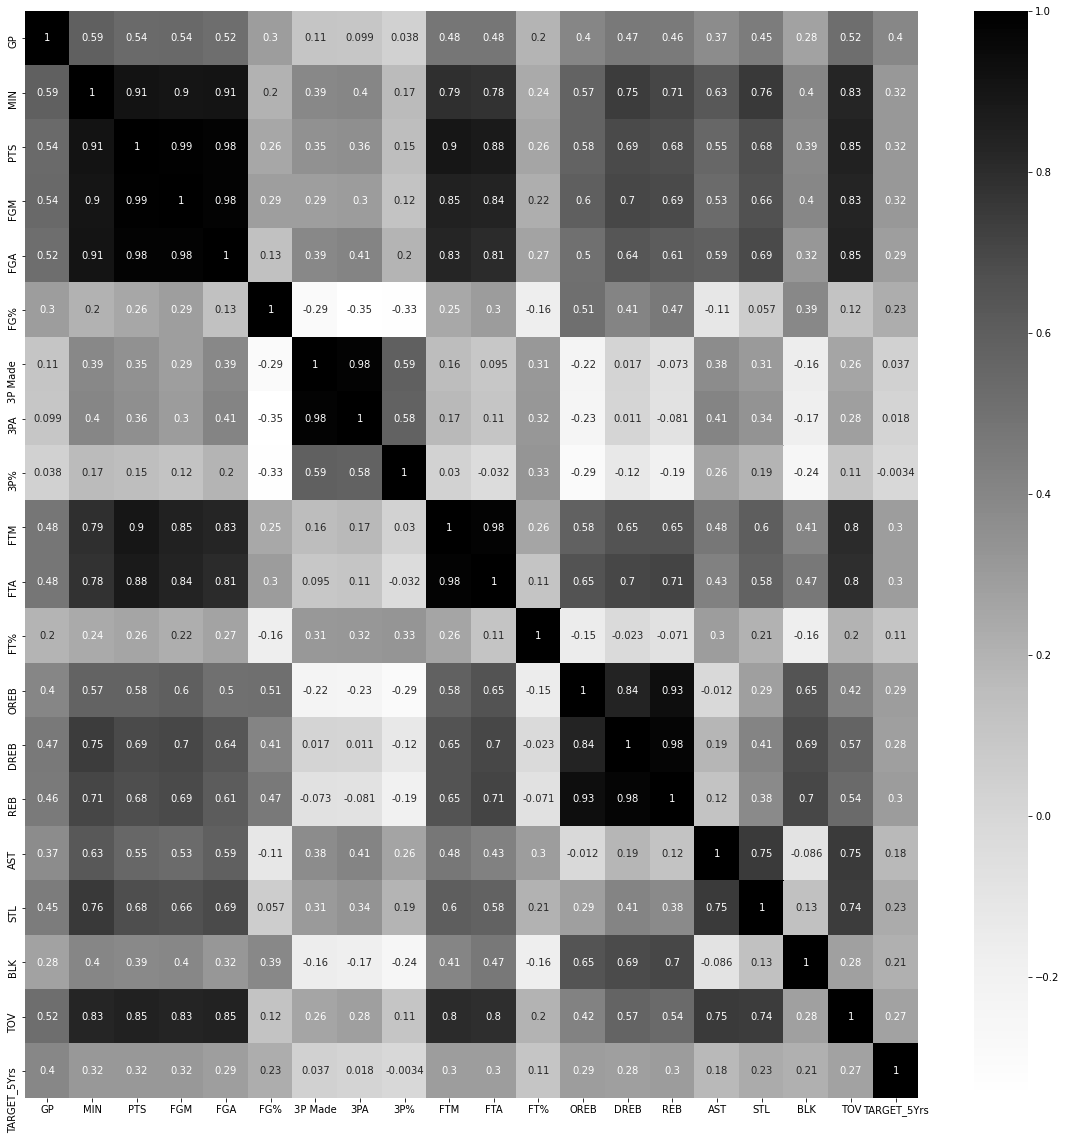

In [5]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,cmap="Greys")

In [6]:
Highly_correlated_df = pd.DataFrame(columns=['Feature 1','Feature 2','Correlation Coefficient'])
correlation_mat = df.corr()
columns = correlation_mat.columns
correlation_mat.shape[1]
for row in range(correlation_mat.shape[0]):
    for col in range(correlation_mat.shape[1]): 
        if correlation_mat.iloc[row][col]>0.9 and correlation_mat.index[row]!= columns[col]:
            Highly_correlated_df = Highly_correlated_df.append({'Feature 1':correlation_mat.index[row],'Feature 2':columns[col],'Correlation Coefficient':correlation_mat.iloc[row][col]}, ignore_index=True)
            
table = pd.pivot_table(Highly_correlated_df,index=['Feature 1','Feature 2'])
table

Correlation Coefficient
Feature 1 Feature 2                         
3P Made   3PA                       0.982616
3PA       3P Made                   0.982616
DREB      REB                       0.978177
FGA       FGM                       0.980050
          MIN                       0.910247
          PTS                       0.979733
FGM       FGA                       0.980050
          MIN                       0.903060
          PTS                       0.990834
FTA       FTM                       0.980505
FTM       FTA                       0.980505
MIN       FGA                       0.910247
          FGM                       0.903060
          PTS                       0.911822
OREB      REB                       0.932694
PTS       FGA                       0.979733
          FGM                       0.990834
          MIN                       0.911822
REB       DREB                      0.978177
          OREB                      0.932694

From above correlation matrix, we found set of independent variables which are highly correlated with each other:
1. 3P Made, 3PA,
2. DREB, REB
3. FGA, FGA, MIN, PTS,
4. FTA, FTM,
5. OREB, REB.

It means that our dataset contains multicollinearity. We should remove multicollinearity by dropping columns which has high correlation.
This observation will be helpful to evaluate the performance of the model using AIC.

In [7]:
X1 = X.drop(columns=['3P Made', '3PA', 'DREB', 'FGA', 'FGA', 'MIN', 'PTS', 'FTA', 'FTM', 'OREB', 'REB'],axis=1)
X1

,Name,GP,FGM,FG%,3P%,FT%,AST,STL,BLK,TOV
0,128,36,2.6,34.7,25.0,69.9,1.9,0.4,0.4,1.3
1,45,35,2.0,29.6,23.5,76.5,3.7,1.1,0.5,1.6
2,521,74,2.0,42.2,24.4,67.0,1.0,0.5,0.3,1.0
3,820,58,2.3,42.6,22.6,68.9,0.8,0.6,0.1,1.0
4,871,48,1.6,52.4,0.0,67.4,0.3,0.3,0.4,0.8
...,...,...,...,...,...,...,...,...,...,...
1335,223,80,1.6,43.3,14.3,79.2,2.5,0.6,0.2,0.8
1336,135,68,1.5,35.8,16.7,79.4,2.3,0.8,0.0,1.3
1337,855,43,2.2,55.0,0.0,64.3,0.3,0.3,0.4,0.9
1338,795,52,1.7,43.9,10.0,62.5,2.2,0.4,0.1,0.8


<AxesSubplot:>

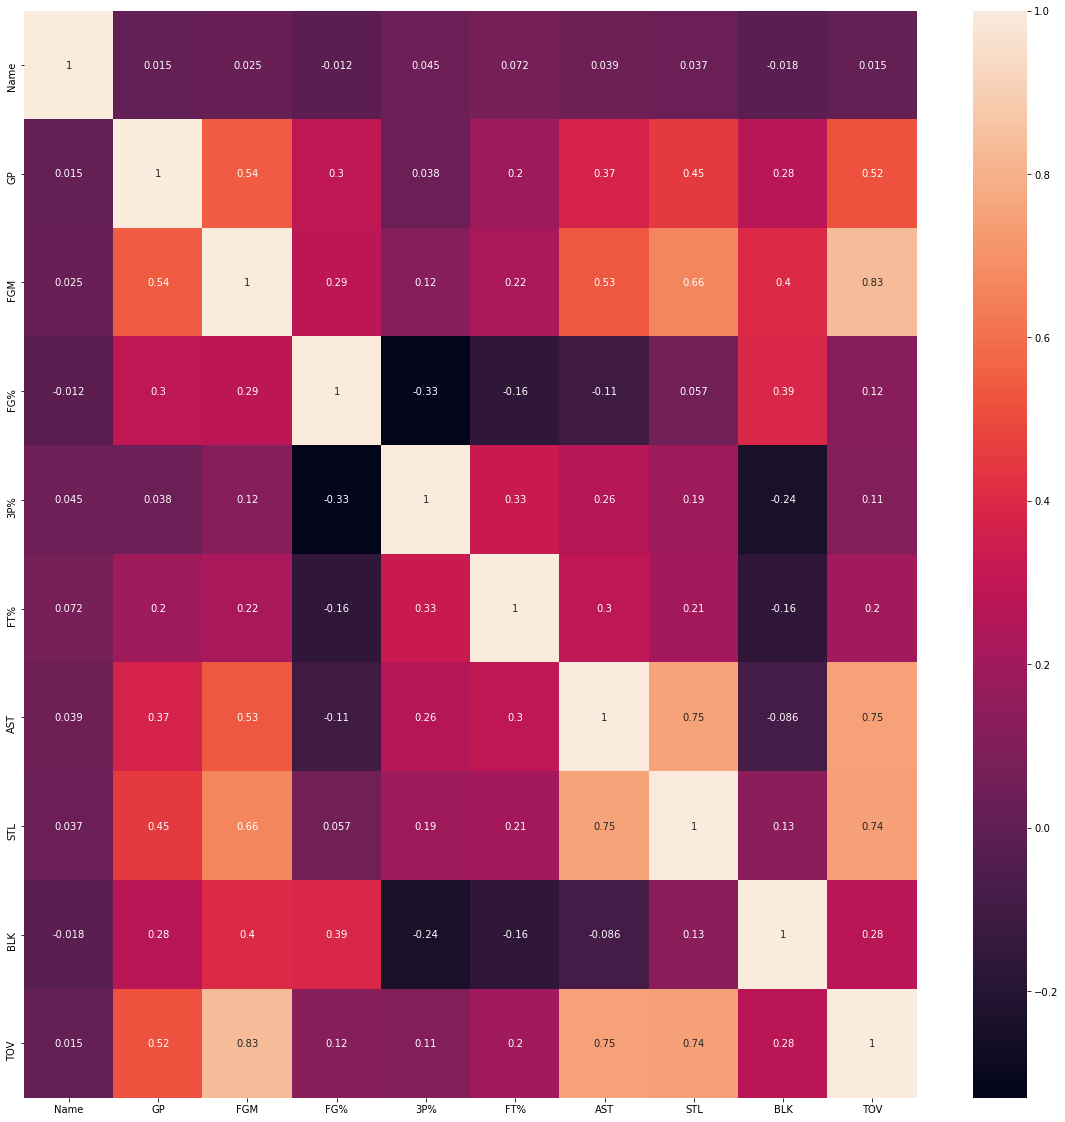

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(X1.corr(),annot=True)

### iii. All observations are independent of each other.

In [9]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(X)
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is nan
Independent (H0 holds true)


In [10]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(X1)
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is nan
Independent (H0 holds true)


### iv. There are No Extreme Outliers.

<Figure size 14400x14400 with 0 Axes>

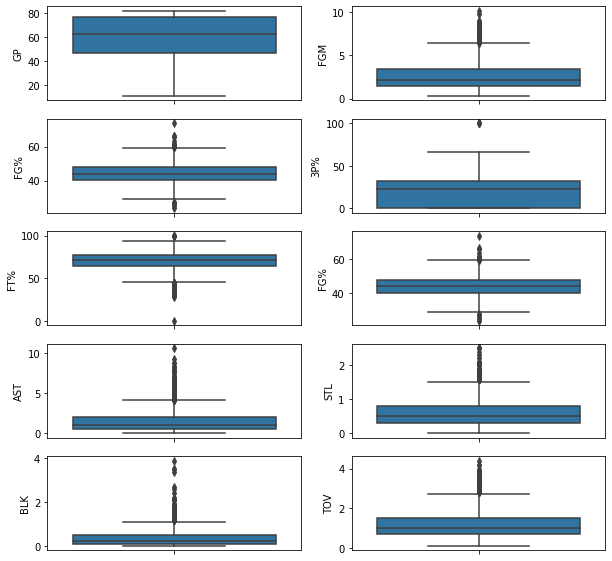

In [11]:
plt.figure(figsize = (200,200))
fig, axes = plt.subplots(5, 2,figsize = (10,10))
sns.boxplot(data=df, y='GP', ax=axes[0,0])
sns.boxplot(data=df, y='FGM', ax=axes[0,1])
sns.boxplot(data=df, y='FG%', ax=axes[1,0])
sns.boxplot(data=df, y='3P%', ax=axes[1,1])
sns.boxplot(data=df, y='FT%', ax=axes[2,0])
sns.boxplot(data=df, y='FG%', ax=axes[2,1])
sns.boxplot(data=df, y='AST', ax=axes[3,0])
sns.boxplot(data=df, y='STL', ax=axes[3,1])
sns.boxplot(data=df, y='BLK', ax=axes[4,0])
sns.boxplot(data=df, y='TOV', ax=axes[4,1])
plt.show()

In [12]:
temp_df = X
temp_df['TARGET_5Yrs'] = Y
temp_df
columns = X.columns
upper_limit = list(range(X.shape[1]))
lower_limit = list(range(X.shape[1]))

for col in range(X.shape[1]):
    upper_limit[col] = np.mean(X[columns[col]]) + 3*np.std(X[columns[col]])
    lower_limit[col] = np.mean(X[columns[col]]) - 3*np.std(X[columns[col]])
    
lower_limit
for col in range(temp_df.shape[1]):   
    temp_df = temp_df[(temp_df[columns[col]] < upper_limit[col]) & (temp_df[columns[col]] > lower_limit[col])]
X = temp_df.drop('TARGET_5Yrs',axis=1)
Y = temp_df['TARGET_5Yrs']

In [13]:
temp_df = X1
temp_df['TARGET_5Yrs'] = Y
columns = X1.columns
upper_limit = list(range(X1.shape[1]))
lower_limit = list(range(X1.shape[1]))

for col in range(X1.shape[1]):
    upper_limit[col] = np.mean(X1[columns[col]]) + 3*np.std(X1[columns[col]])
    lower_limit[col] = np.mean(X1[columns[col]]) - 3*np.std(X1[columns[col]])
    
lower_limit
for col in range(temp_df.shape[1]):   
    temp_df = temp_df[(temp_df[columns[col]] < upper_limit[col]) & (temp_df[columns[col]] > lower_limit[col])]
X1 = temp_df.drop('TARGET_5Yrs',axis=1)
Y1 = temp_df['TARGET_5Yrs']

## Check categories of outcome

In [14]:
Y.unique()

array([0., 1.])

The response variable is a binary.
## Split dataset into training and test dataset

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=40)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.3, random_state=40)
print(X_train1.shape)
print(X_test1.shape)
print(Y_train1.shape)
print(Y_test1.shape)


(819, 10)
(352, 10)
(819,)
(352,)


## Build and train Logistic Regression Model

In [16]:
logreg_model = LogisticRegression(max_iter=2000)
logreg_model.fit(X_train, Y_train)
logreg_model1 = LogisticRegression(max_iter=2000)
logreg_model1.fit(X_train1, Y_train1)

LogisticRegression(max_iter=2000)

## Measure the performance of the model

In [17]:
Y_pred = logreg_model.predict(X_test)
print("Accuracy score of Logistic Regression : ",logreg_model.score(X_test, Y_test))

Y_pred1 = logreg_model1.predict(X_test1)
print("Accuracy score of Logistic Regression : ",logreg_model1.score(X_test1, Y_test1))

Accuracy score of Logistic Regression :  0.6789772727272727
Accuracy score of Logistic Regression :  0.6903409090909091


## Evaluate the performance of Logistic Regression model
### 1. AIC ( Akaike Information Criteria)
To calculate the AIC of several regression models in Python, we can use the <b><i>statsmodels.regression.linear_model.OLS()</i></b> function, which has a property called aic that tells us the AIC value for a given model.

In [18]:
import statsmodels.api as sm
#add constant to predictor variables
x = sm.add_constant(X_train)

#fit regression model
model = sm.OLS(Y_train, x).fit()

#view AIC of model
print(model.aic)

#add constant to predictor variables
x = sm.add_constant(X_train1)

#fit regression model
model = sm.OLS(Y_train1, x).fit()

#view AIC of model
print(model.aic)

1033.2534012968636
1034.8316425105875


Since the second model has a lower AIC value, it is the better fitting model. 

### 2. Confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(Y_test,Y_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(Y_test,Y_pred,labels=[1,0])
print('Classification report : \n',matrix)

# confusion matrix
matrix = confusion_matrix(Y_test1,Y_pred1, labels=[1,0])
print('Confusion matrix : \n',matrix)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(Y_test1,Y_pred1,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[164  35]
 [ 78  75]]
Classification report : 
               precision    recall  f1-score   support

           1       0.68      0.82      0.74       199
           0       0.68      0.49      0.57       153

    accuracy                           0.68       352
   macro avg       0.68      0.66      0.66       352
weighted avg       0.68      0.68      0.67       352

Confusion matrix : 
 [[162  37]
 [ 72  81]]
Classification report : 
               precision    recall  f1-score   support

           1       0.69      0.81      0.75       199
           0       0.69      0.53      0.60       153

    accuracy                           0.69       352
   macro avg       0.69      0.67      0.67       352
weighted avg       0.69      0.69      0.68       352



In [20]:
from sklearn.metrics import precision_score
print('Precision value of first model : ',precision_score(Y_test,Y_pred))
print('Precision value of second model : ',precision_score(Y_test1,Y_pred1))

Precision value of first model :  0.6776859504132231
Precision value of second model :  0.6923076923076923


Precision value of second model is better.
### 3. ROC curve (Receiver Operating Characteristic)

roc_auc_score for Logistic Regression:  0.7417972214011233


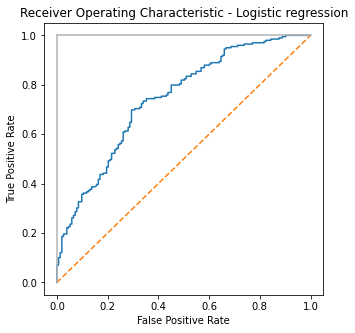

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_score1 = logreg_model.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_score1)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(Y_test, y_score1))

plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

roc_auc_score for Logistic Regression:  0.7403849311919073


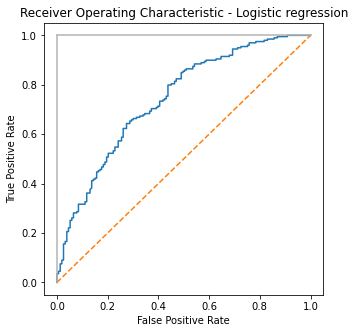

In [22]:
y_score1 = logreg_model1.predict_proba(X_test1)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test1, y_score1)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(Y_test1, y_score1))

plt.subplots(1, figsize=(5,5))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Higher the value of AUC better its ability to distinguish between positive and negative classes.

### 4. Null deviance and residual deviance

In [23]:
def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)

print(deviance(X_test, Y_test,logreg_model))
print(deviance(X_test1, Y_test1,logreg_model1))

415.13569044357075
417.7199448080263


Residual deviance of the first model is less as compared to the second model. Hence, first model is better to fit.